# Population Genetics and Information Theory: A First Approach

In [1]:
#%reset
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
# Import matplotlib's new default colormap (necessary only until matplitlib 2.0 release)
%run ./option_d.py
import scipy.special
import scipy.misc
from scipy import stats
from scipy import optimize
from scipy import misc
from sympy import *
from sympy import init_printing
init_printing(use_unicode=True) # print outputs in LaTeX


# Seaborn, useful for graphics
import seaborn as sns

# Import libraries to parallelize processes
from joblib import Parallel, delayed

from itertools import product
from functools import reduce

# JB's favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 'axes.labelsize': 15, 'axes.titlesize': 18}
sns.set_context('notebook', rc=rc)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'


## A haploid population subject to selection pressures only. 

###Assumes infinite possible population size (very large population); very short generation span; constant selection.

##Growth Equation from First Principles for Selection

In [2]:
#%reset
#The equation for the number of individuals in the group:
N_p= Function('N_p')
N_q= Function('N_q')
N_p0= Symbol('N_p0')
N_q0= Symbol('N_q0')
N_0= Symbol('N_0')
C1= Symbol('C1')
t= Symbol('t')
s= Symbol('s')
N_0= N_p0 + N_q0 #The population size at t= 0 is N_0, the sum of NP and NQ
N_p= dsolve(Eq(N_p(t).diff(t), N_p(t)*(1+s))) #Set up the mating system, Np has beneficial allele
N_p= N_p.subs(C1, N_p0) #Set the integration constant
N_q= dsolve(Eq(N_q(t).diff(t), N_q(t))) #Set up the mating system, Nq has neutral allele
N_q= N_q.subs(C1, N_q0) #Set the integration constant
N_p

##Renormalization yields allele frequency, 'p'

In [3]:
#Figure out the allele freq's, p and q
p= Function('p'); q= Function('q'); a= Symbol('a'); b= Symbol('b'); p_0= Symbol('p_0'); q_0= Symbol('q_0'); c= Symbol('c')
#continuous equation for allele p with selective advantage 's'
#equation obtained by writing growth equation from first principles (view above equation, N_i) and re-normalizing. 
p= p_0*exp(s*t)/(p_0*exp(s*t)+1-p_0) #same form as the Fermi Function! Here, st is equivalent to k_bT
p
p_num= lambdify([p_0, s, t], p, 'numpy') #numeric approx

##Shannon Entropy

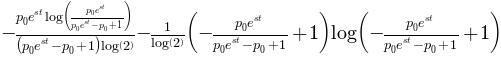

In [4]:
#Shannon Entropy Equatiom
def ShannonEntropy(p):
    if p!= 1:
        if p!= 0:
            S= -p*log(p)/log(2)-(1-p)*log(1-p)/log(2)
    return S

P= Symbol('P')
ShannonEntropy_num= lambdify(P, ShannonEntropy(P), 'numpy')
ShannonEntropy(p)

#Plot Results

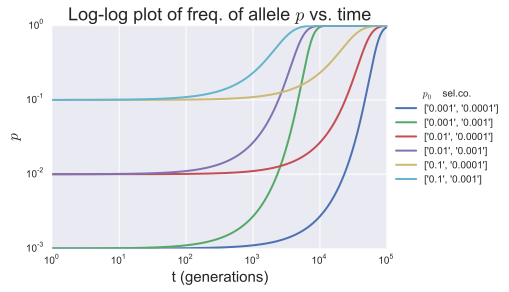

In [5]:
p0_arr= [0.001, 0.01, 0.1]
s_arr= [10**-4, 10**-3]
t_arr= np.linspace(0, 10**5, 10**5)

ax= plt.subplot(111)
for p0 in p0_arr:
    for sel in s_arr:
        plt.plot(t_arr, p_num(p0, sel, t_arr), label= [str(p0), str(sel)])
plt.xscale('log')
plt.yscale('log')
plt.margins(0.01)
ax.legend(loc='center left', title=r'$p_0 \;$ sel.co.', bbox_to_anchor=(1, 0.5))
plt.xlabel(r't (generations)')
plt.ylabel(r'$p$')
plt.title(r'Log-log plot of freq. of allele $p$ vs. time')


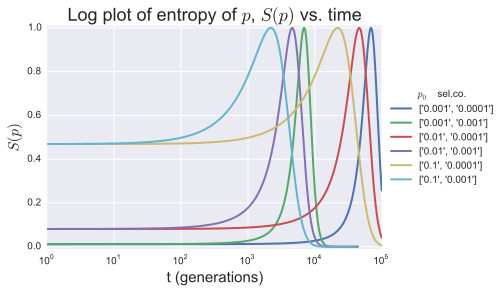

In [6]:
p0_arr= [0.001, 0.01, 0.1]
s_arr= [10**-4, 10**-3]
t_arr= np.linspace(0, 10**5, 10**5)

ax= plt.subplot(111)
for p0 in p0_arr:
    for sel in s_arr:
        simulation= p_num(p0, sel, t_arr)
        plt.plot(t_arr, ShannonEntropy_num(simulation), label= [str(p0), str(sel)])

plt.xscale('log')
plt.margins(0.01)
plt.legend(loc=2, title=r'$p_0 \; sel.co.$')
ax.legend(loc='center left', title=r'$p_0 \;$ sel.co.', bbox_to_anchor=(1, 0.5))
plt.xlabel(r't (generations)')
plt.ylabel(r'$S(p)$')
plt.title(r'Log plot of entropy of $p$, $S(p)$ vs. time')


##A haploid population subject to selection and mutation

##Renormalized equations

In [7]:
#Figure out the allele freq's, p and q
p= Function('p'); q= Function('q'); a= Symbol('a'); b= Symbol('b'); p_0= Symbol('p_0'); q_0= Symbol('q_0'); c= Symbol('c')
l= Symbol('l'); s= Symbol('s'); pp= Symbol('pp'); p0= Symbol('p0')

#continuous equation for allele p with mutation rate 'l', and given that allele 'q' has selective
#disadvantage equal to 's'
p= 1*p0/(p0*(1+l/s)+(1-p0-l/s*p0)*exp(-s*t)) #still some version of the Fermi Equation
p
p_num= lambdify([p0, l, s, t], p, 'numpy')

##Results

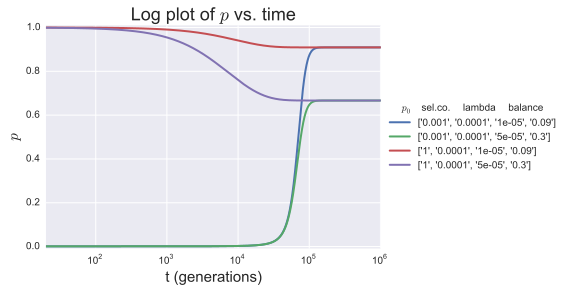

In [8]:
p0_arr= [0.001,1]
s_arr= [10**-4]
l_arr= [10**-5, 1/2*10**-4]
t_arr= np.linspace(2*10*1, 10**6, 10**6)

ax= plt.subplot(111)
for p_init in p0_arr:
    for ll in l_arr:
        for sel in s_arr:
            simulation= p_num(p_init, ll, sel, t_arr)
            plt.plot(t_arr, simulation,  label= [str(p_init), str(sel), str(ll), str('{0:.1}'.format(ll/(sel+ll)))])

plt.xscale('log')
plt.margins(0.01)
plt.legend(loc=2, title=r'$p_0 \; sel.co.$')
ax.legend(loc='center left', title=r'$p_0 \;$ sel.co. $\;$ lambda $\;$ balance', bbox_to_anchor=(1, 0.5))
plt.xlabel(r't (generations)')
plt.ylabel(r'$p$')
plt.title(r'Log plot of $p$ vs. time')

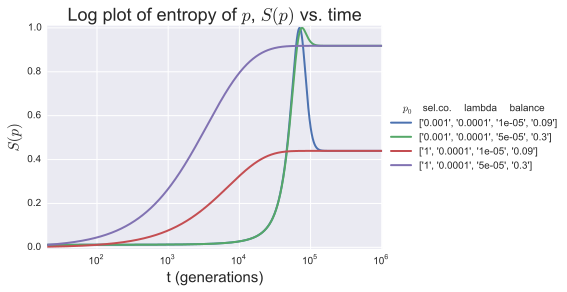

In [9]:
ax= plt.subplot(111)
for p_init in p0_arr:
    for ll in l_arr:
        for sel in s_arr:
            simulation= p_num(p_init, ll, sel, t_arr)
            plt.plot(t_arr, ShannonEntropy_num(simulation), label= [str(p_init), str(sel), str(ll), str('{0:.1}'.format(ll/(sel+ll)))])

plt.xscale('log')
plt.margins(0.01)
plt.legend(loc=2, title=r'$p_0 \; sel.co.$')
ax.legend(loc='center left', title=r'$p_0 \;$ sel.co. $\;$ lambda $\;$ balance', bbox_to_anchor=(1, 0.5))
plt.xlabel(r't (generations)')
plt.ylabel(r'$S(p)$')
plt.title(r'Log plot of entropy of $p$, $S(p)$ vs. time')


####Above, notice the change in behaviour when p0 changes between 0.001 and 1 -- it's not quite a bifurcation, but certainly there is a qualitative change in behaviour of the function. The change happens when p_inf == q_inf